# Logistic Regression

Simple example of logistic regression in STAN

In [89]:
import numpy as np
from numpy import newaxis
import scipy.special

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

import pystan

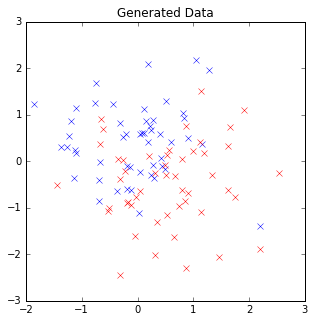

In [105]:
np.random.seed(1)
N = 100
x = np.random.multivariate_normal([0, 0], np.identity(2), size=N)

beta  = np.array([1, -1])
alpha = 0
p = scipy.special.expit(x.dot(beta) + alpha)
r = np.random.uniform(size=N)
category = r < p
x0 = x[~category]
x1 = x[category]
y = np.array(category, dtype='int')

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title('Generated Data')
ax.plot(x0[:,0], x0[:,1], 'bx')
ax.plot(x1[:,0], x1[:,1], 'rx')
fig.show()

In [41]:
import pystan
model_code = """
data {
    int<lower=0> N;
    int<lower=1> D;

    int<lower=0, upper=1> y[N];
    vector[D] x[N];
}

parameters {
    matrix[1,D] beta;
    real alpha;
}

model {
    to_vector(beta) ~ normal(0, 5);
    alpha ~ normal(0, 5);

    for (n in 1:N)
        y[n] ~ bernoulli_logit(beta * x[n] + alpha);
}
"""
model = pystan.StanModel(model_code=model_code)

In [106]:
fit = model.sampling(data=dict(N=N, D=2, x=x, y=y))
print fit

Inference for Stan model: anon_model_b81c86a687567183c11432f471aeeb31.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]   1.12    0.01   0.35   0.49   0.88   1.11   1.34   1.87  979.0    1.0
beta[0,1]  -1.43    0.01   0.35  -2.16  -1.66  -1.42  -1.19   -0.8 1060.0    1.0
alpha      -0.29  7.7e-3   0.26   -0.8  -0.45  -0.29  -0.12   0.22 1098.0    1.0
lp__      -52.23    0.04   1.23 -55.36 -52.77 -51.93 -51.32 -50.86  806.0    1.0

Samples were drawn using NUTS(diag_e) at Thu Mar  3 15:37:03 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [86]:
samples = fit.extract()
alpha = samples['alpha']
beta  = samples['beta'].reshape(-1,2)

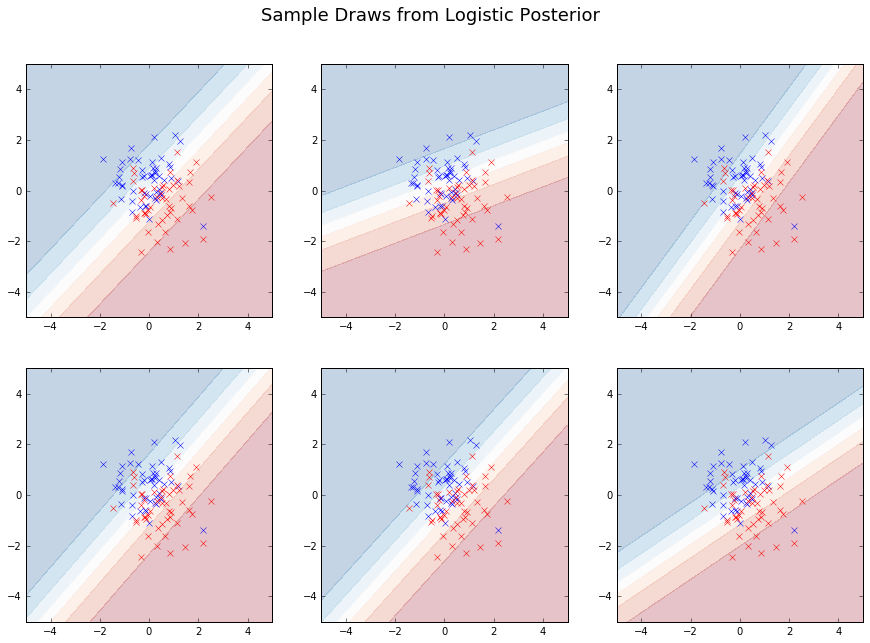

In [96]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))

def logistic_plot(alpha, beta, ax=plt):
    xx = np.linspace(-5, 5)
    yy = np.linspace(-5, 5)
    xv, yv = np.meshgrid(xx, yy)

    nu = (beta[0] * xv) + (beta[1] * yv) + alpha
    z = 1 / (1 + np.exp(-nu))

    ax.plot(x0[:,0], x0[:,1], 'bx')
    ax.plot(x1[:,0], x1[:,1], 'rx')
    ax.contourf(xx, yy, z, cmap='RdBu_r', alpha=0.25)

for ax in axs.flatten():
    n = np.random.randint(len(alpha))
    alpha_p = alpha[n]
    beta_p  = beta[n]
    logistic_plot(alpha_p, beta_p, ax=ax)

fig.suptitle("Sample Draws from Logistic Posterior", fontsize=18)
fig.show()

# Emergent Non-Linearity 

When using bayesian inference, even linear models can exhibit non-linearity when expectations are taken over the full posterior distribution.

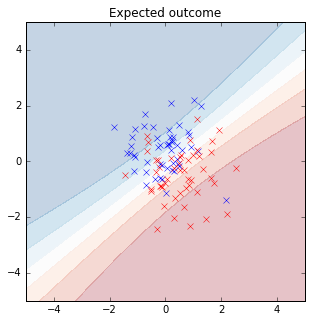

In [104]:
xx = np.linspace(-5, 5)
yy = np.linspace(-5, 5)
xv, yv = np.meshgrid(xx, yy)

xnu = beta[:,0,newaxis,newaxis] * xv[newaxis,:,:]
ynu = beta[:,1,newaxis,newaxis] * yv[newaxis,:,:]
nu  = xnu + ynu + alpha[:,newaxis,newaxis]

z = 1 / (1 + np.exp(-nu))

z_mean = z.mean(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x0[:,0], x0[:,1], 'bx')
ax.plot(x1[:,0], x1[:,1], 'rx')
ax.contourf(xx, yy, z_mean, cmap='RdBu_r', alpha=0.25)
ax.set_title('Expected outcome')

fig.show()